# `Agent` **to** `Agent retrieval`
Based on [Build an agent-to-agent retrieval solution using Azure AI Search](https://learn.microsoft.com/en-us/azure/search/search-agentic-retrieval-how-to-pipeline?tabs=search-perms), this article describes an approach or pattern for building a solution that uses Azure AI Search for knowledge retrieval, and how to integrate knowledge retrieval into a custom solution that includes Azure AI Agent. This pattern uses an agent tool to invoke an agentic retrieval pipeline in Azure AI Search.<br/>
This exercise differs from the [Agentic Retrieval Quickstart](https://learn.microsoft.com/en-us/azure/search/search-get-started-agentic-retrieval?tabs=search-perms%2Csearch-endpoint&pivots=programming-language-python) in how it uses Azure AI Agent to retrieve data from the index, and how it uses an agent tool for orchestration. If you want to understand the retrieval pipeline in its simplest form, begin with the quickstart.

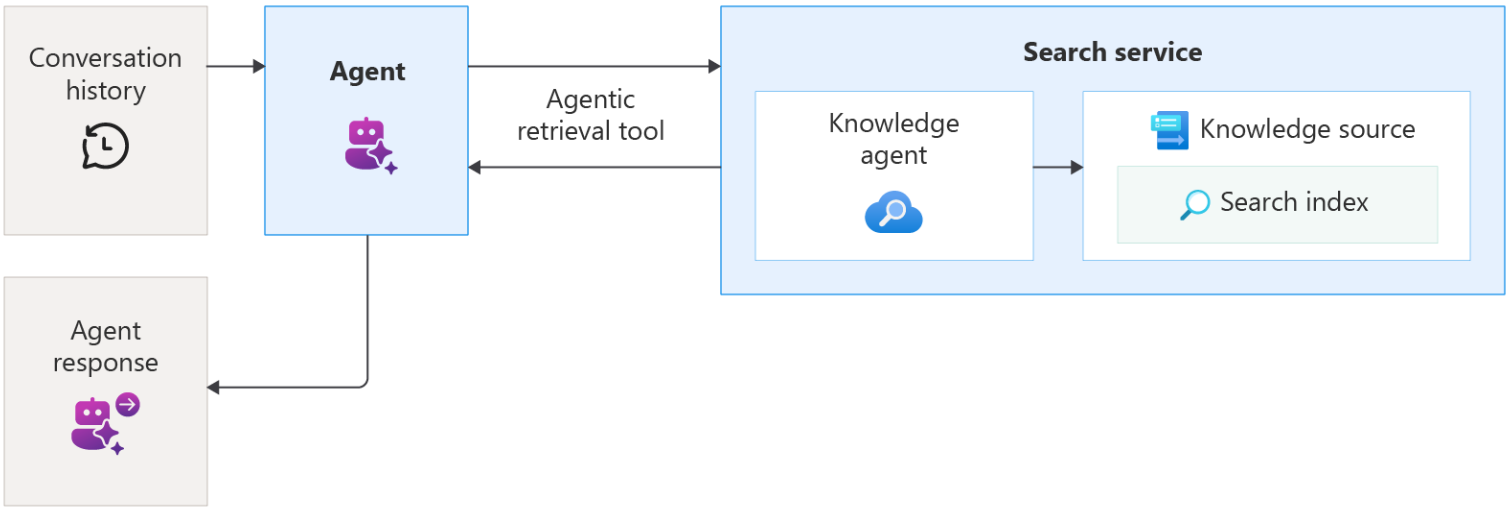

# Constants and Libraries

In [1]:
import os
from IPython.display import Markdown, display
from dotenv import load_dotenv # requires python-dotenv
from PIL import Image # requires pip install pillow
from datetime import datetime
import importlib.metadata

if not load_dotenv("./../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
else:
    print("Environment variables have been loaded ;-)")

project_endpoint = os.environ["AIF_STD_PROJECT_ENDPOINT"]
api_version = os.environ["OPENAI_API_VERSION"] # at least "2025-03-01-preview"

print(f'Project Endpoint: <{project_endpoint}>')
print(f"azure-ai-projects library installed version: {importlib.metadata.version("azure-ai-projects")}")
print(f"azure-ai-agents library installed version: {importlib.metadata.version("azure-ai-agents")}")

Environment variables have been loaded ;-)
Project Endpoint: <https://aif2stdsvhdu2.services.ai.azure.com/api/projects/aif2stdwusprj01hdu2>
azure-ai-projects library installed version: 1.0.0
azure-ai-agents library installed version: 1.1.0


# Create AI Foundry Project Client

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    endpoint=project_endpoint,
    credential=DefaultAzureCredential(),
)

# just for testing: list current AI Foundry Agents in the project
agents = project_client.agents.list_agents()

print(f"Agents in project <{project_endpoint.split("/")[-1][:-1]}>:")
for a in agents:
    print(f"- {a.id}: {a.name}")

Agents in project <aif2stdwusprj01hdu>:
- asst_ccLBOOnW6O0ueExE5Awi84ci: agentic_retrieval-agent
- asst_abjXdVPhkyab4N5YhL53C0lf: agentic_retrieval-agent
- asst_wVTUXhAMkkokPrHvFNaBsOKT: agentic_retrieval-agent
- asst_yWHh0WgwqpkoO5IhqwtteLSG: agentic_retrieval-agent
- asst_M62N86KM8qsQDDuxzPpTS0wa: agentic_retrieval-agent
- asst_yeHqeqfAOcq9yUmeiTBQ82fg: agentic_retrieval-agent
- asst_uOFSwsSRjMUKSrFt3oSVYmj1: agentic_retrieval-agent
- asst_fXlFxIWmTTmJgxELiNym3Nzd: agentic_retrieval-agent
- asst_lsIWSNGwab0viResLOfevTIO: agentic_retrieval-agent
- asst_SuxfZu9gtacfaYw4epUC1aLq: agentic_retrieval-agent
- asst_AoWjHilDdmOPy5dAKFeIdAZ7: agentic_retrieval-agent
- asst_TT99AeiCWRo4ab534CxGIlE1: agentic_retrieval-agent
- asst_1m52lvS4zoLdOkgn1XYHUrCB: agentic_retrieval-agent
- asst_R9ol3uG4ehHDG1LOM2MlUneX: agentic_retrieval-agent
- asst_a7wPsvFqE1lax4u58yTOdK5H: agentic_retrieval-agent
- asst_u7FMzCXsqLCxk46QIeMSqbUC: agentic_retrieval-agent
- asst_1ke6wW3jSDoyp1ew7pe60bw4: agentic_retriev

# `Just for testing`: check if the agent exists

In [3]:
from azure.search.documents.indexes import SearchIndexClient

knowledge_agent_name = os.environ["knowledge_agent_name"]
search_endpoint = os.environ["search_endpoint"]

index_client = SearchIndexClient(endpoint=search_endpoint, credential=DefaultAzureCredential())

knowledge_agent = next(
    (a for a in index_client.list_agents() if a.name == knowledge_agent_name),
    None  # default if not found
)

if knowledge_agent:
    print("Found agent:\n", knowledge_agent)
else:
    print(f"Agent '{knowledge_agent_name}' not found. Please crete it before running the cells below.")

Found agent:
 {'additional_properties': {}, 'name': 'earth-knowledge-agent', 'models': [<azure.search.documents.indexes._generated.models._models_py3.KnowledgeAgentAzureOpenAIModel object at 0x7e87b946b8c0>], 'knowledge_sources': [<azure.search.documents.indexes._generated.models._models_py3.KnowledgeSourceReference object at 0x7e87b946ba10>], 'output_configuration': <azure.search.documents.indexes._generated.models._models_py3.KnowledgeAgentOutputConfiguration object at 0x7e87b946bb60>, 'request_limits': None, 'retrieval_instructions': None, 'e_tag': '"0x8DDFE95A030F95A"', 'encryption_key': None, 'description': None}


# Define the Agentic Retrieval Custom Function

In [4]:
from typing import List, Dict
def space_science_retrieval(messages: List[Dict[str, str]]) -> dict:
    """
    Thanks to Searches a wide knowledge about images of Earth at night and other science related facts, this function provides science answers to questions related to astronomy and space matters. The returned string is in a JSON format that contains the reference id. Be sure to use the same format in your agent's response. You must refer to references by id number.
    :param messages: The list of messages of the conversation, where the final one is the question to answer.
    :return: a JSON object with grounding response, activity and references.
    """

    print("Received messages:", messages)
    
    from azure.search.documents.agent import KnowledgeAgentRetrievalClient
    from azure.search.documents.agent.models import KnowledgeAgentRetrievalRequest, KnowledgeAgentMessage, KnowledgeAgentMessageTextContent, SearchIndexKnowledgeSourceParams
    from azure.identity import DefaultAzureCredential    

    knowledge_source_name = os.environ["knowledge_source_name"]

    search_endpoint = os.environ["search_endpoint"]
    knowledge_agent_name = os.environ["knowledge_agent_name"]
    search_api_version = os.environ["search_api_version"]
    
    req = KnowledgeAgentRetrievalRequest(
        messages=[
            KnowledgeAgentMessage(
                role=m["role"],
                content=[KnowledgeAgentMessageTextContent(text=m["content"])]
            ) for m in messages if m["role"] != "system"
        ],
        knowledge_source_params=[
            SearchIndexKnowledgeSourceParams(
                knowledge_source_name=knowledge_source_name,
                kind="searchIndex"
            )
        ]
    )

    
    agent_client = KnowledgeAgentRetrievalClient(endpoint=search_endpoint, agent_name=knowledge_agent_name, credential=DefaultAzureCredential())

    retrieval_result = agent_client.retrieve(retrieval_request=req, api_version=search_api_version)

    print(f"references that will be returned:\n{retrieval_result.references}")

    # Return the grounding response to the agent
    return {
        "response": retrieval_result.response,
        "activity": retrieval_result.activity,
        "references":  retrieval_result.references
    }

# `Just for testing`: invoking Custom Function

In [5]:
query_1 = """
    Why do suburban belts display larger December brightening than urban cores even though absolute light levels are higher downtown?
    Why is the Phoenix nighttime street grid is so sharply visible from space, whereas large stretches of the interstate between midwestern cities remain comparatively dim?
    """

messages = []

messages.append({
    "role": "user",
    "content": query_1
})

import textwrap
import json

result = space_science_retrieval(messages=messages)

print("Response")
print(textwrap.fill(result["response"][0].content[0].text, width=120))

print("+++++++++++++++++++++++\n\n")
print("Activity")
print(json.dumps([a.as_dict() for a in result["activity"]], indent=2))

print("+++++++++++++++++++++++\n\n")
print("References")
print(json.dumps([r.as_dict() for r in result["references"]], indent=2))

Received messages: [{'role': 'user', 'content': '\n    Why do suburban belts display larger December brightening than urban cores even though absolute light levels are higher downtown?\n    Why is the Phoenix nighttime street grid is so sharply visible from space, whereas large stretches of the interstate between midwestern cities remain comparatively dim?\n    '}]
references that will be returned:
[<azure.search.documents.agent._generated.models._models_py3.KnowledgeAgentSearchIndexReference object at 0x7e87b94ceba0>, <azure.search.documents.agent._generated.models._models_py3.KnowledgeAgentSearchIndexReference object at 0x7e87b92bed50>, <azure.search.documents.agent._generated.models._models_py3.KnowledgeAgentSearchIndexReference object at 0x7e87b92bee90>, <azure.search.documents.agent._generated.models._models_py3.KnowledgeAgentSearchIndexReference object at 0x7e87b912c770>, <azure.search.documents.agent._generated.models._models_py3.KnowledgeAgentSearchIndexReference object at 0x7e

# Consolidate the custom functions into a single set

In [6]:
from typing import Any, Callable, Set

user_functions: Set[Callable[..., Any]] = {
    space_science_retrieval
}

user_functions

{<function __main__.space_science_retrieval(messages: List[Dict[str, str]]) -> dict>}

# Initialize FunctionTool and ToolSet

## Remember to enable `auto_function_calls`!

In [7]:
from azure.ai.agents.models import FunctionTool, ToolSet

functions = FunctionTool(user_functions)
toolset = ToolSet()
toolset.add(functions)
project_client.agents.enable_auto_function_calls(tools=toolset)

print(f"functions.definitions: {functions.definitions}")
print(f"\nfunctions.resources: {functions.resources}")

functions.definitions: [{'type': 'function', 'function': {'name': 'space_science_retrieval', 'description': "Thanks to Searches a wide knowledge about images of Earth at night and other science related facts, this function provides science answers to questions related to astronomy and space matters. The returned string is in a JSON format that contains the reference id. Be sure to use the same format in your agent's response. You must refer to references by id number.", 'parameters': {'type': 'object', 'properties': {'messages': {'type': 'array', 'items': {'type': 'object'}, 'description': 'The list of messages of the conversation, where the final one is the question to answer.'}}, 'required': ['messages']}}}]

functions.resources: {}


# Create AI Foundry Agent with the `toolset`

In [8]:
# definitions pretty print

def format_tool_definitions(definitions):
    def custom_serializer(obj):
        return obj.__dict__ if hasattr(obj, '__dict__') else str(obj)

    function_dict = {item['function']['name']: item['function'] for item in functions.definitions}

    return json.dumps(function_dict, indent=2, default=custom_serializer)

print(format_tool_definitions (functions.definitions))

{
  "space_science_retrieval": {
    "_data": {
      "name": "space_science_retrieval",
      "description": "Thanks to Searches a wide knowledge about images of Earth at night and other science related facts, this function provides science answers to questions related to astronomy and space matters. The returned string is in a JSON format that contains the reference id. Be sure to use the same format in your agent's response. You must refer to references by id number.",
      "parameters": {
        "type": "object",
        "properties": {
          "messages": {
            "type": "array",
            "items": {
              "type": "object"
            },
            "description": "The list of messages of the conversation, where the final one is the question to answer."
          }
        },
        "required": [
          "messages"
        ]
      }
    }
  }
}


In [9]:
instructions = """
A Q&A agent that can answer questions about the Earth at night.
If you don't have the answer, respond with "I don't know".

**++++RULES++++**
When you invoke the tool, remember to **ALWAYS** pass it the list of messages as an array of dictionaries.
**ALWAYS** reported references to the detailed scientific explanations.
"""

agent = project_client.agents.create_agent(
    model=os.environ["aoai_gpt_deployment"],
    name="agentic_retrieval-agent",
    instructions=instructions,
    toolset=toolset
)

agent.items

<bound method _MyMutableMapping.items of {'id': 'asst_n0kFhad4tuCPpf7k3vAF3qNS', 'object': 'assistant', 'created_at': 1759098878, 'name': 'agentic_retrieval-agent', 'description': None, 'model': 'gpt-4.1-mini', 'instructions': '\nA Q&A agent that can answer questions about the Earth at night.\nIf you don\'t have the answer, respond with "I don\'t know".\n\n**++++RULES++++**\nWhen you invoke the tool, remember to **ALWAYS** pass it the list of messages as an array of dictionaries.\n**ALWAYS** reported references to the detailed scientific explanations.\n', 'tools': [{'type': 'function', 'function': {'name': 'space_science_retrieval', 'description': "Thanks to Searches a wide knowledge about images of Earth at night and other science related facts, this function provides science answers to questions related to astronomy and space matters. The returned string is in a JSON format that contains the reference id. Be sure to use the same format in your agent's response. You must refer to refe

# Create the thread and attach a new message to it

In [10]:
# Create a thread
thread = project_client.agents.threads.create()
print(f"Created thread: {thread}\n")

# Add a user message to the thread
from azure.ai.agents.models import MessageRole

message_content = """
    Why do suburban belts display larger December brightening than urban cores even though absolute light levels are higher downtown?
    Why is the Phoenix nighttime street grid is so sharply visible from space, whereas large stretches of the interstate between midwestern cities remain comparatively dim?
    """

message = project_client.agents.messages.create(
    thread_id=thread.id, 
    role=MessageRole.USER, 
    content=message_content,
)
print(f"Created message: {message}")


# let's see the messages associated with the thread
list(project_client.agents.messages.list(thread_id=thread.id))

Created thread: {'id': 'thread_zpb1ne1Ae8KNj9avJhcZzA6n', 'object': 'thread', 'created_at': 1759098879, 'metadata': {}, 'tool_resources': {}}

Created message: {'id': 'msg_S6ccteHQxmPuSBZMzcGlWznW', 'object': 'thread.message', 'created_at': 1759098880, 'assistant_id': None, 'thread_id': 'thread_zpb1ne1Ae8KNj9avJhcZzA6n', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': '\n    Why do suburban belts display larger December brightening than urban cores even though absolute light levels are higher downtown?\n    Why is the Phoenix nighttime street grid is so sharply visible from space, whereas large stretches of the interstate between midwestern cities remain comparatively dim?\n    ', 'annotations': []}}], 'attachments': [], 'metadata': {}}


[{'id': 'msg_S6ccteHQxmPuSBZMzcGlWznW', 'object': 'thread.message', 'created_at': 1759098880, 'assistant_id': None, 'thread_id': 'thread_zpb1ne1Ae8KNj9avJhcZzA6n', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': '\n    Why do suburban belts display larger December brightening than urban cores even though absolute light levels are higher downtown?\n    Why is the Phoenix nighttime street grid is so sharply visible from space, whereas large stretches of the interstate between midwestern cities remain comparatively dim?\n    ', 'annotations': []}}], 'attachments': [], 'metadata': {}}]

# Run the agent synchronously
**Note**: if you get "incomplete" due to content filtering, please try running the same cell again

In [11]:
%%time

# Run the agent
run = project_client.agents.runs.create_and_process\
    (thread_id=thread.id, agent_id=agent.id)

print(f"Run finished with status: {run.status}.\n\nRun: {run}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to get more quota
    print(f"Run failed: {run.last_error}")

Error executing function 'space_science_retrieval': space_science_retrieval() missing 1 required positional argument: 'messages'
Tool outputs contain errors - retrying


Received messages: [{'role': 'user', 'content': 'Why do suburban belts display larger December brightening than urban cores even though absolute light levels are higher downtown? Why is the Phoenix nighttime street grid so sharply visible from space, whereas large stretches of the interstate between midwestern cities remain comparatively dim?'}]
references that will be returned:
[<azure.search.documents.agent._generated.models._models_py3.KnowledgeAgentSearchIndexReference object at 0x7e87b92db890>, <azure.search.documents.agent._generated.models._models_py3.KnowledgeAgentSearchIndexReference object at 0x7e87b92dee00>]
Run finished with status: RunStatus.COMPLETED.

Run: {'id': 'run_D3hhDHOZRJHUXBxVbBF5vwbX', 'object': 'thread.run', 'created_at': 1759098883, 'assistant_id': 'asst_n0kFhad4tuCPpf7k3vAF3qNS', 'thread_id': 'thread_zpb1ne1Ae8KNj9avJhcZzA6n', 'status': 'completed', 'started_at': 1759098907, 'expires_at': None, 'cancelled_at': None, 'failed_at': None, 'completed_at': 17590989

# Fetch messages from the thread after the agent run execution

In [12]:
from azure.ai.agents.models import (MessageTextContent, MessageImageFileContent, MessageTextFileCitationAnnotation, \
    MessageTextFilePathAnnotation, MessageTextUrlCitationAnnotation)

image_files = []
annotations = []
citations = []
citation_annotations = []

if run.status == 'completed':
    messages = project_client.agents.messages.list(thread_id=thread.id)
    messages_list = list(project_client.agents.messages.list(thread_id=thread.id))  # Convert iterator to a list
    messages_nr = len(messages_list)
    print(f"Here are the {messages_nr} messages:\n")
    
    for i, message in enumerate(reversed(messages_list), 1):
        j = 0
        print(f"\n===== MESSAGE {i} =====")
        for c in message.content:
            j +=1
            if (type(c) is MessageTextContent):
                print(f"\nMessage {i} / CONTENT {j} (MessageTextContent) --> Text: {c.text.value}")
                for a in c.text.annotations:
                    if type(a) is MessageTextFileCitationAnnotation:
                        print(f">>> Citation in MessageTextContent {j} of message {i}: {a}\n")
                        citations.append(a)
                    elif type(a) is MessageTextFilePathAnnotation:
                        print(f">>> Annotation in MessageTextContent {j} of message {i}: {a}\n")
                        annotations.append(a)
                    elif type(a) is MessageTextUrlCitationAnnotation:
                        print(f">>> Annotation in MessageTextContent {j} of message {i}: {a}\n")
                        citation_annotations.append(a)
                    else:
                        print(f"Unknown type {type(a)}")
            elif (type(c) is MessageImageFileContent):
                print(f"\nMessage {i} / CONTENT {j} (MessageImageFileContent) --> image_file id: {c.image_file.file_id}")
                image_files.append(c.image_file.file_id)
            else:
                print(f"Unknown type {type(a)}")

else:
    print(f"Sorry, I can't proceed because the run status is {run.status}")

Here are the 2 messages:


===== MESSAGE 1 =====

Message 1 / CONTENT 1 (MessageTextContent) --> Text: 
    Why do suburban belts display larger December brightening than urban cores even though absolute light levels are higher downtown?
    Why is the Phoenix nighttime street grid is so sharply visible from space, whereas large stretches of the interstate between midwestern cities remain comparatively dim?
    

===== MESSAGE 2 =====

Message 2 / CONTENT 1 (MessageTextContent) --> Text: Suburban belts display larger December brightening than urban cores despite having lower absolute light levels because of several factors related to lighting usage and seasonal behaviors. In suburban areas, residential lighting such as holiday decorations significantly increases brightness in December, whereas urban cores already have consistently high lighting levels throughout the year, making the relative increase less noticeable. Suburban areas also tend to have less dense lighting at other times o